<a href="https://colab.research.google.com/github/HeningWang/AC-2022-Empty-Set/blob/main/normal_logis_30k_restraint_prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import modules and dependencies


In [103]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!git clone https://github.com/HeningWang/numpyro_adjective_modelling.git
!pip install siuba

import os

from IPython.display import set_matplotlib_formats
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
numpyro.set_platform("gpu")

plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

assert numpyro.__version__.startswith("0.12.1")

  Preparing metadata (setup.py) ... done
fatal: destination path 'numpyro_adjective_modelling' already exists and is not an empty directory.


In [104]:
print(jax.__version__)
jax.devices()

0.4.13


[gpu(id=0)]

In [105]:
import sys
sys.path.append('/content/numpyro_adjective_modelling')

Some helper functions:

<ipython-input-106-81d508f2d9d9>:27: RuntimeWarning: divide by zero encountered in true_divide


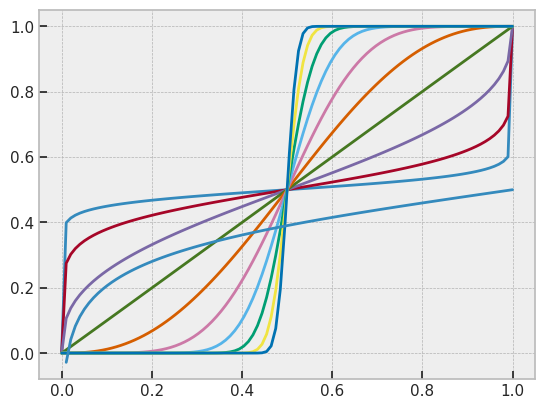

In [106]:
import numpy as np
from scipy.stats import norm

%matplotlib inline
from scipy.special import betainc
import numpy as np
import math
import matplotlib.pyplot as plt

x = np.linspace(0., 1., 100)
N = 10

for i in range(N):
    k = 0.5 * np.exp(i) / N
    plt.plot(x, betainc(k, k, x))

#plt.gca().set_xlim(0,1)
#plt.gca().set_ylim(0,1)
#plt.show()

def link_function_S(x, param=None):
  N = 10
  k = 0.5 * jnp.exp(param) / N
  return jax.scipy.stats.beta.cdf(x,k,k)

def logit_function(x, k):
    return -jnp.log(1 / x * 2 - 1) / k + 0.5

x = np.linspace(0., 1., 100)
y = logit_function(x, 10)
plt.plot(x,y)

In [107]:
# Mutate the dataset to include the states of the objects
# ... states are independent variables for models

def extract_states(line):
    states = []
    for i in range(6):
      color = 1 if line[10 + i] == "blue" else 0
      form = 1 if line[16 + i] == "circle" else 0
      new_obj = (line[4 + i], color, form)
      states.append(new_obj)
    return jnp.array(states)


# Transform/rescale slider value from range 0 to 100 to 0 to 1
# ... in order to match predicted probability from models

def transformation_data(slider_value, link = None):
    if link == "identity":
      slider_value = jnp.clip(slider_value, 0, 100)
      transformed_prob = slider_value / 100
    elif link == "logit":
        transformed_prob = 1 / (1 + math.exp(-slider_value))
    return transformed_prob

def link_function(x, param = 1):
    return 1 / (1 + jnp.exp(param * -(x - 0.5)))

def compute_alpha_beta_concentration(mu, v):
    alpha = mu * v
    beta = (1 - mu) * v
    return alpha, beta

def Marginal(fn):
    return memoize(lambda *args: HashingMarginal(Search(fn).run(*args)))

def plot_dist(d, ax=None):
    support = d.enumerate_support()
    data = [d.log_prob(s).exp().item() for s in d.enumerate_support()]
    names = list(map(str, support))

    if ax is None:
        ax = plt.subplot(111)

    width = 0.3
    bins = [x-width/2 for x in range(1, len(data) + 1)]
    ax.bar(bins,data,width=width)
    ax.set_xticks(list(range(1, len(data) + 1)))
    ax.set_xticklabels(names, rotation=45, rotation_mode="anchor", ha="right")

def get_results(posterior):
    results = {}
    support = posterior.enumerate_support()
    data = [posterior.log_prob(s).exp().item() for s in posterior.enumerate_support()]
    results["support"] = support
    results["probs"] = data
    return results

def normalize(arr, axis=1):
    """
    Normalize arr along axis
    """
    return arr / arr.sum(axis, keepdims=True)

In [108]:
# Import dataset
dataset_url = "/content/numpyro_adjective_modelling/dataset/dataset_slider.csv"
df = pd.read_csv(dataset_url)

# subset data to only include combination dimension_color
df = df[df['combination'] == 'dimension_color']
df.reset_index(inplace=True, drop=True)

# Mutate the dataset to include the states of the objects
df_experiment = df.copy()
df_experiment["states"] = df_experiment.apply(lambda row: extract_states(row), axis=1)

df_experiment.prefer_first_1st = jnp.clip(df_experiment.prefer_first_1st.to_numpy(), 0, 100)
df_experiment.prefer_first_1st = df_experiment.prefer_first_1st/100
print(df_experiment.prefer_first_1st.describe())


count    3125.000000
mean        0.700768
std         0.381771
min         0.000000
25%         0.500000
50%         0.910000
75%         1.000000
max         1.000000
Name: prefer_first_1st, dtype: float64


In [109]:
from sklearn.model_selection import train_test_split
# split the dataset into training and test sets
#train, test = train_test_split(df_experiment, test_size=0.99, random_state=42)

# use the whole dataset as training set
train = df_experiment

print(train.shape)

states_train = jnp.stack([cell for cell in train.states])
empirical_train = jnp.array(train.prefer_first_1st.to_numpy())

(3125, 27)


In [110]:
def get_threshold_kp(states, k=0.5):
    min_val = jnp.min(states[:,0])
    max_val = jnp.max(states[:,0])
    threshold = max_val - k * (max_val - min_val)
    return threshold

def get_threshold_kp_weighted(states, states_prior, k=0.5):
    sorted_indices = jnp.unique(jnp.argsort(states[:, 0] * states_prior), size = 6)
    sorted_states = states[sorted_indices]
    min_val = sorted_states[0, 0]
    max_val = sorted_states[-1, 0]

    weighted_threshold = max_val - k * (max_val - min_val)

    return weighted_threshold

def get_threshold_kp_sample(states, states_prior, k=0.5):
    sample_indices = jnp.unique(dist.Categorical(probs=states_prior).sample(random.PRNGKey(0),(1,10)), size = 6)
    sorted_states = states[sample_indices][:,0]
    min_val = jnp.min(sorted_states)
    max_val = jnp.max(sorted_states)

    weighted_threshold = max_val - k * (max_val - min_val)

    return weighted_threshold


def adjMeaning(word, obj, current_state_prior, color_semvalue=0.98, form_semvalue=0.98, wf=0.6, k=0.5):
    colors = [1]  # Specify the color values
    sizes = [0]  # Specify the size values

    if word == 1:
        return numpyro.sample("color", numpyro.distributions.Bernoulli(color_semvalue)) if word == obj[1] else numpyro.sample("color", numpyro.distributions.Bernoulli(1 - color_semvalue))
    elif word == 0:
        threshold = get_threshold_kp(current_state_prior, k)
        size = obj[0]
        prob_big = 1 - dist.Normal(size - threshold, wf * jnp.sqrt(size ** 2 + threshold ** 2)).cdf(jnp.array([0.0]))
        return numpyro.sample("size", numpyro.distributions.Bernoulli(prob_big))


In [111]:
# Example usage for meaning function
#states = jnp.array([[10., 1., 1.],
#                   [3., 1., 1.],
#                   [3., 1., 1.],
#                   [3., 1., 0.],
#                   [3., 1., 0.],
#                   [1., 0., 1.]], dtype=jnp.float32)

#word = 0 # Example word, 0 for size
#obj = states[5]  # Example object from states

# Example prior values
#color_semvalue = 0.98
#form_semvalue = 0.98
#wf = 0.6
#k = 0.5

#print(get_threshold_kp(states))
# Call the meaning function
#with handlers.seed(rng_seed=27):
# meaning = adjMeaning(word, obj, states, color_semvalue, form_semvalue, wf, k)

#print(meaning)
#print(obj)

In [112]:
# The length of states is 6

def get_size_semval(size,threshold,wf):
  return 1 - dist.Normal(size - threshold, wf * jnp.sqrt(size ** 2 + threshold ** 2)).cdf(0.0)

def literal_listener_one_word(states, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  probs_blue = jnp.where((1. == states[:, 1]), color_semvalue, 1 - color_semvalue)
  threshold = get_threshold_kp(states, k)
  probs_big = jnp.array([1 - dist.Normal(obj[0] - threshold, wf * jnp.sqrt(obj[0] ** 2 + threshold ** 2)).cdf(0.0) for obj in states])
  probs = normalize(jnp.array([probs_big,probs_blue]))
  return probs

def literal_listener_recursive(word_length, states, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5, weighted = False):
  if word_length <= 1:
    current_states_prior = jnp.ones((2,6))
  else:
    current_states_prior = literal_listener_recursive(word_length - 1, states, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5)
    current_states_prior = jnp.flip(current_states_prior, axis = 0)
  probs_blue = jnp.where((1. == states[:, 1]), color_semvalue, 1 - color_semvalue)
  if weighted:
    threshold = get_threshold_kp_sample(states, current_states_prior[0,:], k)
  else:
    threshold = get_threshold_kp(states, k)
  probs_big = jax.vmap(get_size_semval, in_axes = (0, None, None))(states[:,0], threshold, wf)
  probs = normalize(jnp.multiply(jnp.array([probs_big,probs_blue]), current_states_prior))
  return probs


def speaker_one_word(states, alpha = 1, bias = 0, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  listener = literal_listener_one_word(states, color_semvalue, form_semvalue,wf,k)
  bias_weights = jnp.array([0, 1]) * bias
  util_speaker = jnp.log(jnp.transpose(listener)) - bias_weights
  softmax_result = jax.nn.softmax(alpha * util_speaker)
  return softmax_result

def speaker_recursive(word_length, states, alpha = 1, bias = 0, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  if word_length <= 1:
    current_utt_prior = jnp.array([0, 1]) * bias
  else:
    current_utt_prior = speaker_recursive(word_length - 1, states, alpha, bias, color_semvalue, form_semvalue, wf, k)
    current_utt_prior = jnp.flip(current_utt_prior, axis = 1)
  listener = literal_listener_recursive(word_length, states, color_semvalue, form_semvalue, wf, k)
  #print(listener)
  util_speaker = jnp.log(jnp.transpose(listener)) - current_utt_prior
  softmax_result = jax.nn.softmax(alpha * util_speaker)
  return softmax_result

def global_speaker(states, alpha = 1, bias = 0, color_semvalue = 0.98, form_semvalue = 0.98, wf = 0.6, k = 0.5):
  listener = literal_listener_recursive(2,states, color_semvalue, form_semvalue,wf,k)
  bias_weights = jnp.array([0, 1]) * bias
  util_speaker = jnp.log(jnp.transpose(listener)) - bias_weights
  softmax_result = jax.nn.softmax(alpha * util_speaker)
  return softmax_result


In [113]:
# 118 brdc sharp, target not the biggest
# 12 brdc blurred

# 119 erdc sharp
# 15 erdc blurred

index = 15
states_manuell = jnp.array([[10., 1., 1.],
                   [3., 1., 1.],
                   [3., 1., 1.],
                   [3., 1., 0.],
                   [3., 1., 0.],
                   [1., 0., 1.]], dtype=jnp.float32)

#states_example = states_manuell
states_example = df_experiment.iloc[index, df_experiment.columns.get_loc("states")]
condition = df_experiment.iloc[index, df_experiment.columns.get_loc("conditions")]
distribution = df_experiment.iloc[index, df_experiment.columns.get_loc("sharpness")]
preference = df_experiment.iloc[index, df_experiment.columns.get_loc("prefer_first_1st")]
print(states_example)
print(condition + " " + distribution)
print(preference)
#print(f"literal listener one word: {literal_listener_one_word(states_example)}")
#print(f"literal listener two words: {literal_listener_recursive(2,states_example)}")
#print(f"model_prediction: {model_speaker[0][0]}")
#print(f"speaker one word: {speaker_one_word(states_example)}")
print(f"speaker two words global: {global_speaker(states_example)}")
print("________________________________________")
print(f"speaker two words incremental: {speaker_recursive(2,states_example)}")
print("________________________________________")
print(f"speaker two words incremental: {speaker_recursive(2,states_example, k = 0.1)}")

[[10.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  1.]
 [ 5.  0.  1.]
 [ 5.  0.  1.]
 [ 4.  1.  0.]]
erdc blurred
0.01
speaker two words global: [[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.50000006 0.49999994]
 [0.50000006 0.49999994]
 [0.5        0.5       ]]
________________________________________
speaker two words incremental: [[0.7102522  0.28974777]
 [0.5933295  0.4066705 ]
 [0.5933295  0.4066705 ]
 [0.69769424 0.30230576]
 [0.69769424 0.30230576]
 [0.3327222  0.6672778 ]]
________________________________________
speaker two words incremental: [[0.7642486  0.23575145]
 [0.6889536  0.3110464 ]
 [0.6889536  0.3110464 ]
 [0.69373137 0.30626863]
 [0.69373137 0.30626863]
 [0.32121736 0.6787827 ]]


In [114]:
# index = 120, condition = zrdc sharp, there is a difference in threshold of 0.5
print(f"kp:{get_threshold_kp(states_example,0.5)}")
print(f"kp weighted flat: {get_threshold_kp_weighted(states_example,jnp.ones((2,6)),0.5)}")
print(f"kp weighted: {get_threshold_kp_weighted(states_example,literal_listener_one_word(states_example)[1,:],0.5)}")
print(f"kp weighted: {get_threshold_kp_sample(states_example,literal_listener_one_word(states_example)[1,:],0.5)}")
threshold = 6
1 - dist.Normal(10. - threshold, 0.6 * jnp.sqrt(10. ** 2 + threshold ** 2)).cdf(-0.5)

print(literal_listener_one_word(states_example)[1,:])
# this is also a not normal case, because target has size of 9 instead of 10
# also there is no difference on listener side

kp:5.5
kp weighted flat: 7.0
kp weighted: 7.0
kp weighted: 4.0
[0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.9074074 ]


In [115]:
vectorized_speaker = jax.vmap(speaker_recursive, in_axes=(None,0,None,None,None,None,None,None))
model_prob = vectorized_speaker(2,states_train, 1,1,0.5,0.5,0.5,0.5)
print(jnp.shape(model_prob))
print(jnp.shape(model_prob[:,0,0]))
slider_predict = jax.vmap(link_function, in_axes = (0,None))(model_prob[:,0,0],20)

slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
print(jnp.shape(slider_predict))

(3125, 6, 2)
(3125,)
(3125,)


In [141]:
# define the conditioned model for MCMC
vectorized_speaker = jax.vmap(speaker_recursive, in_axes=(None,0,None,None,None,None,None,None))

def model_inc_utt_parallel_normal(states = None, data = None):
    gamma = numpyro.sample("gamma", dist.HalfNormal(5))
    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0.5, 1))
    form_semvalue = color_semvalue
    k = numpyro.sample("k", dist.Uniform(0, 1))
    wf = 0.5
    bias = numpyro.sample("bias", dist.HalfNormal(5))
    steepness = numpyro.sample("steepness", dist.HalfNormal(0.5))
    sigma = numpyro.sample("sigma", dist.Uniform(0,0.1))

    with numpyro.plate("data",len(states)):
      model_prob = vectorized_speaker(2, states_train, gamma, bias, color_semvalue, form_semvalue, wf, k)
      slider_predict = jax.vmap(link_function, in_axes = (0,None))(model_prob[:,0,0], steepness)
      slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
      if data is not None:
        data = jnp.clip(data, 1e-5, 1 - 1e-5)
      numpyro.sample("obs", dist.TruncatedNormal(slider_predict, sigma, low = 1e-5, high = 1 - 1e-5,), obs=data)

def model_inc_utt_parallel_beta(states = None, data = None):
    gamma = numpyro.sample("gamma", dist.HalfNormal(5))
    color_semvalue = numpyro.sample("color_semvalue", dist.Uniform(0, 1))
    k = numpyro.sample("k", dist.Uniform(0, 1))
    bias = numpyro.sample("bias", dist.HalfNormal(5))
    #steepness = numpyro.sample("steepness", dist.Uniform(0,10))
    v = numpyro.sample("v", dist.Uniform(0,5))

    form_semvalue = color_semvalue
    wf = numpyro.sample("wf", dist.Uniform(0,1))

    with numpyro.plate("data",len(states)):
      model_prob = vectorized_speaker(2, states_train, gamma, bias, color_semvalue, form_semvalue, wf, k)
      #slider_predict = jax.vmap(link_function_S, in_axes = (0,None))(model_prob[:,0,0], 1)
      #slider_predict = jnp.clip(slider_predict, 1e-5, 1 - 1e-5)
      slider_predict = jnp.clip(model_prob[:,0,0], 1e-5, 1 - 1e-5)
      alpha, beta = compute_alpha_beta_concentration(slider_predict, v)
      if data is not None:
        data = jnp.clip(data, 1e-5, 1 - 1e-5)
      numpyro.sample("obs", dist.Beta(alpha, beta), obs=data)

In [142]:
# define the MCMC kernel and the number of samples
rng_key = random.PRNGKey(10)
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model_inc_utt_parallel_normal, dense_mass=True, max_tree_depth=15, target_accept_prob=0.95)
mcmc_inc = MCMC(kernel, num_warmup=2500,num_samples=7500,num_chains=4)
mcmc_inc.run(rng_key_, states_train, empirical_train)

# print the summary of the posterior distribution
mcmc_inc.print_summary()

# Get the MCMC samples and convert to a DataFrame
posterior_inc = mcmc_inc.get_samples()
df_inc = pd.DataFrame(posterior_inc)

# Save the DataFrame to a CSV file
df_inc.to_csv('/content/drive/MyDrive/posterior_inc_utt_slider.csv', index=False)

<ipython-input-142-506b6da6fce7>:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 10000/10000 [05:29<00:00, 30.31it/s, 31 steps of size 1.03e-01. acc. prob=0.98]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
            bias      1.98      0.03      1.98      1.93      2.04   9839.78      1.00
  color_semvalue      0.99      0.00      0.99      0.99      1.00   4682.89      1.00
           gamma      1.36      0.07      1.36      1.25      1.47   6985.41      1.00
               k      0.14      0.09      0.13      0.00      0.27  13991.80      1.00
           sigma      0.10      0.00      0.10      0.10      0.10  26045.62      1.00
       steepness      3.48      0.17      3.46      3.21      3.74   6500.03      1.00

Number of divergences: 0


In [147]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model_inc_utt_parallel_normal, posterior_inc)
predictions = predictive(rng_key_, states = states_train)["obs"]
print(jnp.shape(predictions))

(30000, 3125)


In [148]:
df_pred = df_experiment.filter(["sharpness","relevant_property","states", "prefer_first_1st"])
df_pred["mean_predictions"] = jnp.mean(predictions, axis=0) - 0.5
df_pred["prefer_first_1st"] = df_pred["prefer_first_1st"] - 0.5
df_pred["std_predictions"] = jnp.std(predictions, axis=0)
df_pred

print(df_pred.prefer_first_1st.describe())
print(df_pred.mean_predictions.describe())

count    3125.000000
mean        0.200768
std         0.381771
min        -0.500000
25%         0.000000
50%         0.410000
75%         0.500000
max         0.500000
Name: prefer_first_1st, dtype: float64
count    3125.000000
mean        0.200020
std         0.112136
min         0.020965
25%         0.064228
50%         0.228794
75%         0.322619
max         0.327446
Name: mean_predictions, dtype: float64


In [145]:
from plotnine import *
from siuba import *

In [149]:
aggregated_df_pred = df_pred  >> group_by("sharpness", "relevant_property") >> summarize(mean_empirical = _.prefer_first_1st.mean(), std_empirical = _.prefer_first_1st.std(), mean_pred = _.mean_predictions.mean(), std_pred = _.mean_predictions.std())
print(aggregated_df_pred)

  sharpness relevant_property  mean_empirical  std_empirical  mean_pred  \
0   blurred              both        0.252476       0.329657   0.229292   
1   blurred             first        0.298959       0.299281   0.323198   
2   blurred            second        0.057861       0.424966   0.051598   
3     sharp              both        0.208442       0.379120   0.228848   
4     sharp             first        0.350962       0.269893   0.324515   
5     sharp            second        0.047803       0.443573   0.056699   

   std_pred  
0  0.004639  
1  0.001785  
2  0.014196  
3  0.004643  
4  0.001221  
5  0.010534  


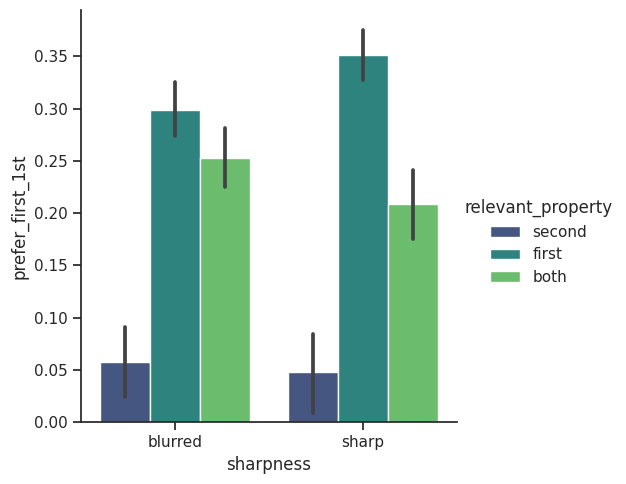

In [150]:
sns.catplot(x='sharpness', y='prefer_first_1st', hue='relevant_property', data=df_pred, kind='bar',
            palette='viridis')

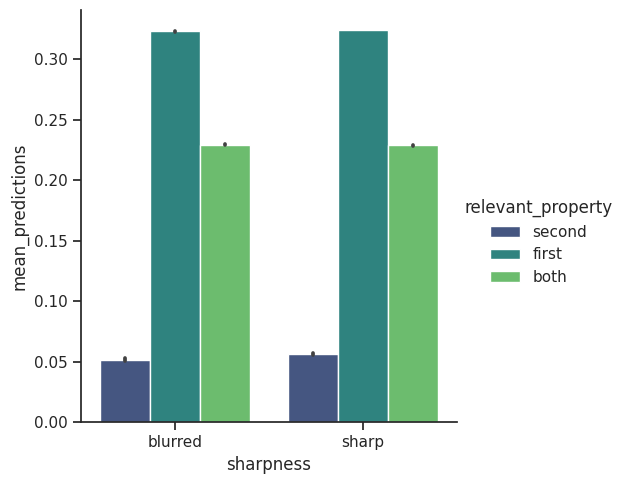

In [151]:
sns.catplot(x='sharpness', y='mean_predictions', hue='relevant_property', data=df_pred, kind='bar',
            palette='viridis')

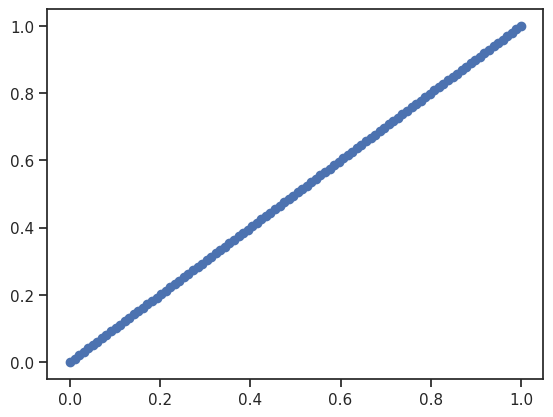

In [152]:
x = np.linspace(0., 1., 100)
plt.scatter(x,x)

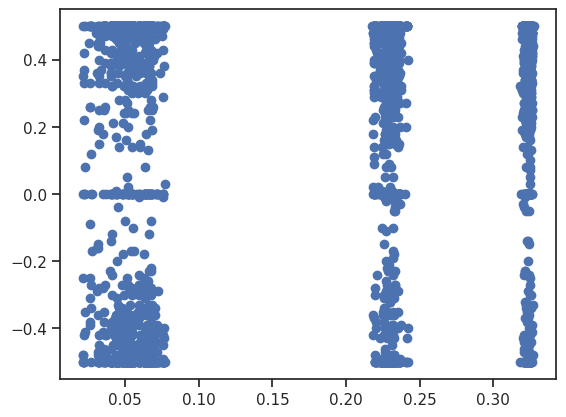

In [153]:
plt.scatter(df_pred.mean_predictions,df_pred.prefer_first_1st)
plt.show()

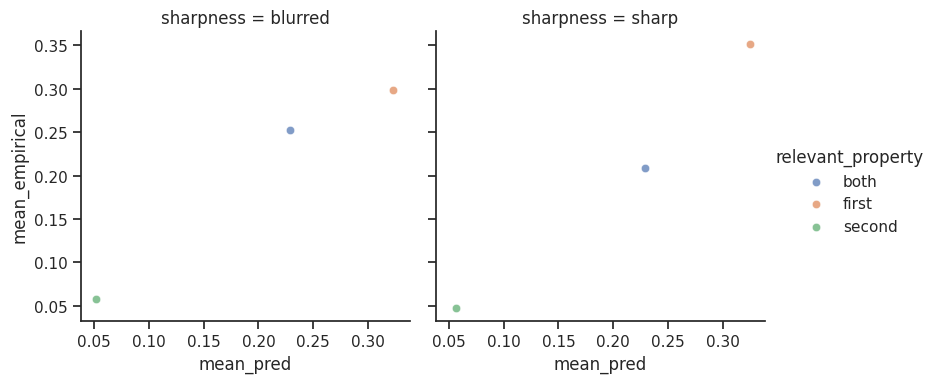

In [154]:
sns.set(style="ticks")

g = sns.FacetGrid(aggregated_df_pred, col="sharpness", hue="relevant_property", height=4)
g.map(sns.scatterplot,"mean_pred", "mean_empirical", alpha=0.7)
g.add_legend()

plt.show()

In [155]:
from sklearn.metrics import r2_score, mean_squared_error

print(f"R2 score between true and predicted data is: {r2_score(df_pred.prefer_first_1st,df_pred.mean_predictions)}")
print(f"MSE between true and predicted data is: {mean_squared_error(df_pred.prefer_first_1st,df_pred.mean_predictions)}")

R2 score between true and predicted data is: 0.08759601019501428
MSE between true and predicted data is: 0.13293973044036597


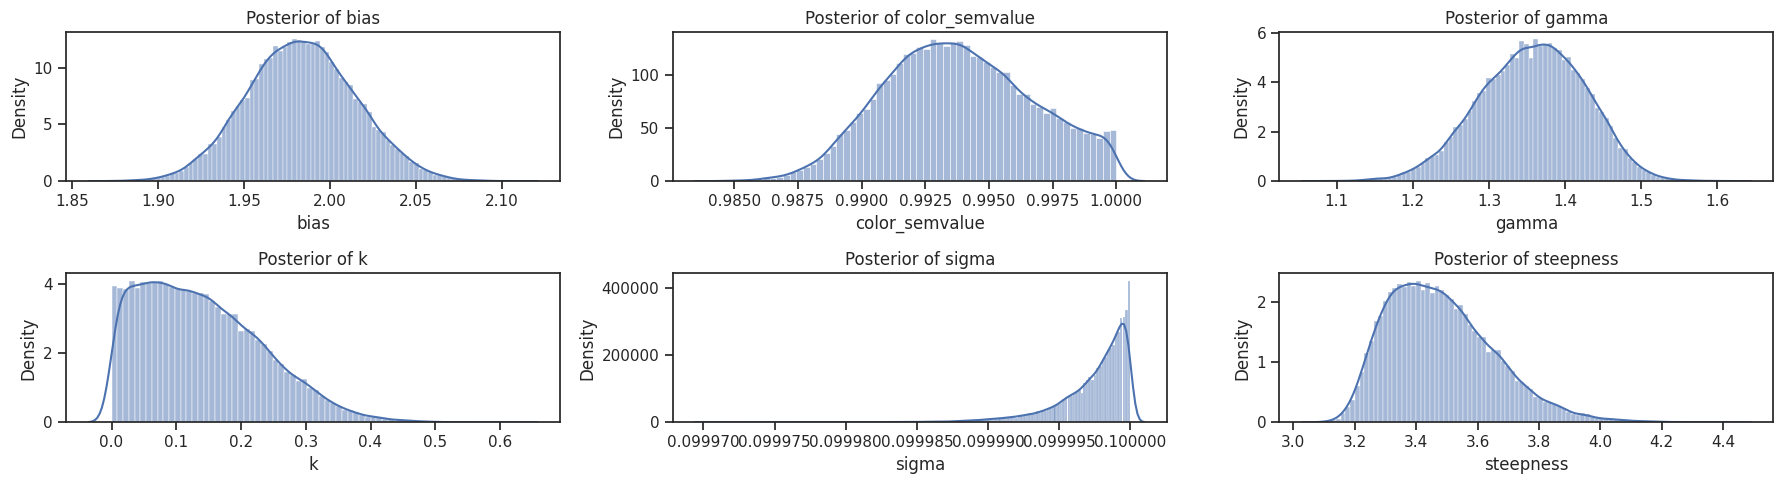

In [156]:
def plot_parameter(df, type = "Posterior"):
    # create subplots based on how many parameters (ncols) we have
    numbers = len(df.columns)
    ncols = 3
    nrows = int(np.ceil(numbers/ncols))
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=(18, 5))
    # plot each parameter
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], kde=True, kde_kws = dict(cut = 3), stat="density", ax=axes[i//ncols, i%ncols])
        axes[i//ncols, i%ncols].set_title(f"{type} of {col}")
    plt.tight_layout()
    plt.show()

plot_parameter(df_inc)